In [1]:
import pymust, pymust.utils
import numpy as np, matplotlib.pyplot as plt, scipy, scipy.io


A rotating disk (diameter of 2 cm) was insonified by a series of 32
unsteered plane waves with a Verasonics scanner, and a linear transducer,
at a PRF (pulse repetition frequency) of 10 kHz. The RF signals were
downsampled at 4/3 times (5 MHz) = 6.66 MHz. The properties of the
linear array were:

- 128 elements
- center frequency = 5 MHz
- pitch = 0.298 mm%%


In [2]:
# Download the experimental RF data. The 3-D array RF contains 128 columns
# (as the transducer contained 128 elements), and its length is 32 in the
# third dimension (as 32 plane waves were transmitted).
dataMatlab = scipy.io.loadmat('Data/PWI_disk.mat', struct_as_record = False); #ok
RF = dataMatlab['RF'].astype(float)


In [3]:
#Parse params
param = pymust.utils.Param();
for k, c in dataMatlab['param'][0][0].__dict__.items():
    if k != '_fieldnames':
        if c.size == 1:
            c = c[0][0]
        param[k] = c

In [4]:
# Demodulate the RF signals with RF2IQ.
IQ =pymust.rf2iq(RF,param); 


In [42]:
#% Create a 2.5-cm-by-2.5-cm image grid.
dx = 1e-4; # grid x-step (in m)
dz = 1e-4; # grid z-step (in m)
x,z = np.meshgrid(np.arange(-1.25e-2, 1.25e-2 +dx,dx), np.arange(1e-2, 3.5e-2+dz-1e-6, dz));


In [43]:
# Create a Delay-And-Sum DAS matrix with DASMTX.
param.fnumber = None; # an f-number will be determined by DASMTX
M = pymust.dasmtx(1j*np.array(IQ.shape[:2]),x,z,param, 'nearest') #nearest does not work


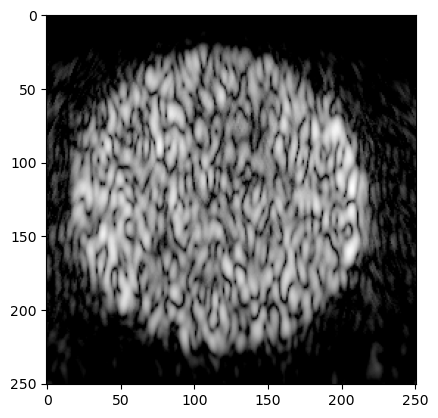

In [44]:
IQb = np.zeros((x.shape[0], x.shape [1], RF.shape[2]), dtype = np.complex128)
for i in range(RF.shape[2]):
    IQb[:,:,i] = pymust.utils.applyDasMTX(M, IQ[:,:,i], x.shape)
I = pymust.bmode(IQb,30);
plt.imshow(I[:,:, 0], cmap ='gray')

In [45]:
param.ROI = np.median(I,2)>64

# Track the speckles with SPTRACK.
param.winsize = np.array([[32,32], [16,16]]); # size of the subwindows
param.iminc = 4; # image increment
Di,Dj,id,jd = pymust.sptrack(I,param);


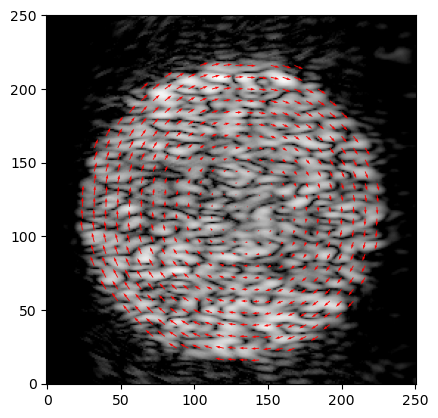

In [46]:
plt.imshow(I[:,:,0].T, cmap = 'gray', origin='lower')
#Need the option of origin = lower, otherwise it will mess up the orientation of the quiver
#https://stackoverflow.com/questions/42776583/superimpose-matplotlib-quiver-on-image
plt.quiver(id, jd, Di, Dj, color = 'r')
